# Several code snippets for the pizza project

The data can be downloaded from the page: http://pizzagan.csail.mit.edu/

There are two types of data: synthetic and real. Use the dataset you want, but beware that they do not have the same labels. They were not originally used for label prediction.



## Path setup for data and networks

In [34]:
# from google.colab import drive

# drive.mount('/content/gdrive/')

DATA_DIR =  './pizzaGANsyntheticdata'


## Useful libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from PIL import Image

from tqdm import tqdm

import seaborn as sns
sns.set_style('darkgrid')

#import shutil

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# scikitlearn
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim
# from torch.optim import lr_scheduler
import torch.nn.functional as F
import torch.nn as nn


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using", "cuda:0" if torch.cuda.is_available() else "cpu")
# verify that the installed cuda version is anterior (or equal) to the cuda version of !nvidia-smi 
# print(torch.version.cuda)

if (torch.cuda.is_available()):
  !nvidia-smi

using cuda:0
Wed Jan 25 23:51:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   76C    P5    21W /  N/A |    774MiB /  5946MiB |     36%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                           

# 0 - Useful functions


In this section, we define all the functions that we will use afterward. First there are the functions used to manage the data, then the functions to train and evaluate the network.

## Data management

### Download dataset and unzip the archive
Uncomment the following lines to do it.

In [3]:
#!cd /content/gdrive/MyDrive/Colab\ Notebooks/Projet\ MI201/

#!ls

#!wget http://pizzagan.csail.mit.edu/pizzaGANsyntheticdata.zip

# !unzip '/content/gdrive/MyDrive/Colab Notebooks/Projet MI201/pizzaGANsyntheticdata' -d '/content/gdrive/MyDrive/Colab Notebooks/Projet MI201'

### Read data

This function allows to build a train, validation and test dataset. It can either use a specific test set and split the train set in the actual train set and the validation set or create a train, validation and test set.

In [4]:
def load_image_list(train_label_path, test_label_path=None, max_image=None, test_size=0.3, val_size=0.2): 
    # get images
    y_all = np.loadtxt(os.path.join(DATA_DIR, train_label_path))
    if max_image is not None: # limit the number of image to max_image
        y_all = y_all[:min(len(y_all), max_image)]
    x_all = np.arange(y_all.shape[0])

    # Create train, val and test splits
    
    if test_label_path is not None: # differentiate when there is a test dataset and when there is just all the data
        x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_size, random_state=123)

        y_test = np.loadtxt(os.path.join(DATA_DIR, test_label_path))
        x_test = np.arange(y_test.shape[0])
    else:
        x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=test_size, random_state=123)
        
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size/(1-test_size), random_state=123)
        
    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)
    
    return x_train, y_train, x_val, y_val, x_test, y_test


### Store train images in memory

This should make learning faster.

In [5]:
def store_image(image_idx, train_data_path, filename, image_format="{:04d}.png", image_size=224):
    # Test if the numpy file exists
    if (os.path.exists(os.path.join(DATA_DIR, train_data_path, filename))):
      img_data_tensor = np.load(os.path.join(DATA_DIR, train_data_path, filename))
      img_all = img_data_tensor['img_data']
    else:
      img_all = []

      for idx in tqdm(image_idx):
          img_name = image_format.format(idx+1)
          x = Image.open(os.path.join(DATA_DIR, train_data_path, 'images', img_name))
          img_all.append(np.array(x.resize((image_size, image_size))))

      np.savez_compressed(os.path.join(DATA_DIR, train_data_path, filename), img_data=np.array(img_all))
    
    return img_all

### Dataset class

In [6]:
class myDataset(Dataset):
    """Pizza dataset"""
    
    def __init__(self, x_idx, y, img_path, img_data = None, transform=None):
      """
      Args:
      """
      self.x_idx = x_idx
      self.y = y
      self.img_path = img_path
      self.transform = transform
      self.img_data = img_data     
    
    def __getitem__(self, idx):
      if isinstance(self.img_data,np.ndarray):
        x = Image.fromarray(self.img_data[idx,:,:,:])
      else:
        img_name = "{:04d}.png".format(idx+1)
        x = Image.open(os.path.join(self.img_path, img_name))
      y = self.y[idx,:]
      if self.transform:
          x = self.transform(x)
      y = np.int64(y)
      return x, y
            
    def __len__(self):
        return int(len(self.x_idx))


### Data loaders

In order to make the code cleaner, we made a function to create the dataset. It is not general and only usable for our case but it also helps to understand how datasets are computed.

In [7]:
def create_dataloader(x_data, y_data, img_data, data_path, datasetClass, batch_size, transform=None, shuffle=False):
    kwargs = {'num_workers': 2, 'pin_memory': True} if torch.cuda.is_available() else {}
    
    if img_data is not None:
        img_data = img_data[x_data, :, :, :]

    raw_dataset = datasetClass(x_data, y_data, img_path=data_path, img_data=img_data, transform = transform)
    dataloader = DataLoader(raw_dataset, batch_size=batch_size, shuffle=shuffle, **kwargs)
    
    return dataloader

## Network training

In [8]:
from IPython.display import clear_output

import copy
import random

def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=5):
  # list for saving accuracies
  train_perf = []
  test_perf = []
  train_losses = []

  # training of the model
  for epoch in range(num_epochs):
      print(epoch,"/",num_epochs)
      model.train()
      for inputs, targets in trainloader:     ## on itere sur les données 
          # inputs is 25 RGB images
          # outputs is 25 targets
          inputs, targets = inputs.cuda(),targets.cuda()

          predictions = model(inputs)    ## on les fait rentrer dans le réseau
          targets = targets.to(torch.float) # FloatTensor needed

          loss = criterion(predictions,targets)    ## on compare la sortie courante à la sortie voulue
          optimizer.zero_grad() ## supprime les gradients courants
          loss.backward() ## le gradient -- la magie par rapport à comment c'était long en cours :-)
          optimizer.step() ## on actualise les poids pour que la sortie courante soit plus proche que la sortie voulue
          train_losses.append(loss)
          train_perf.append(accuracy_score(targets.cpu().numpy(), (predictions.cpu().detach().numpy() > 0.5)))
          if random.randint(0,90)==0:
              print("\tloss=",loss) ## on affiche pour valider que ça diverge pas
         
  # test of the model
  model.eval()
  with torch.no_grad():  ### no need to calculate the gradients
      for inputs, targets in valloader:
          inputs = inputs.cuda()
          outputs = model(inputs)
        
          test_perf.append(accuracy_score(targets.cpu().numpy(), (outputs.cpu().numpy() > 0.5)))
            
  # beep noise when training finished
  !echo -e '\a'
        
# Learning step
  return model, train_perf, test_perf, train_losses


## Network evaluation


An example of performance computation.

The problem being a multi-label prediction, performance metrics are different compared to the ones we used in class. The following ones appeared to be the most frequently used and relevant.



*   Precision : TP/(TP+FP) --> Ability to predict the positive class. Closer to 1 = better
*   Recall : TP/(TP+FN) --> Ability to detect positives. Closer to 1 = better
*   F1-score : 2.precision.recall/(precision+recall)
*   Support : Number of occurences of the label in the true labels


However, the multilabel confusion matrix did not seem useful to us as it uses a one-vs-rest representation for each class.

In [9]:
def model_evaluation(network, nb_labels, dataloader, labels=None, display=0):

  # set the model to evaluation mode
  network.eval()

  # create the vectors necessary for the KPI
  perf_label_test = np.zeros((1,nb_labels))
  all_eval_pred = np.zeros(shape=(0,nb_labels))
  all_eval_targets = np.zeros((0,nb_labels))


  # tell not to reserve memory space for gradients (much faster)
  with torch.no_grad():
      for inputs, targets in tqdm(dataloader, ncols=80):

          inputs = inputs.to(device)
          targets = targets.to(device)

          # Compute outputs
          outputs = network(inputs)
          outputs_np = outputs.cpu().detach().numpy()
          targets_np = targets.cpu().detach().numpy()

          # Compute the predictions
          pred = (outputs_np > 0)

          # Concatenate pred and targets to calculate the classification report
          all_eval_pred = np.concatenate((all_eval_pred, pred))
          all_eval_targets = np.concatenate((all_eval_targets, targets_np))
          # update the performance
          perf_label_test = perf_label_test + (targets_np == pred).sum(axis=0)

          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
          # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report


  # Calculate KPI
  perf_label_test = perf_label_test / len(dataloader.dataset)
  metrics_report = classification_report(all_eval_targets, all_eval_pred, target_names=labels)

  # Prints the classification report and the performance (per label)
  if display==1:
    print("\nAccuracy per label :",perf_label_test)
    print("Mean of accuracy :",sum(perf_label_test[0])/len(perf_label_test[0]))
    print(metrics_report)

  return perf_label_test, metrics_report


### Display what the network guessed

In [10]:
def show_result_on_random_batch(network, labels_name, test_dataloader):
    def label_in_image(vector):
        lbl = []

        for i in range(len(vector)):
            if vector[i]:
                lbl.append(labels_name[i])
        return lbl


    with torch.no_grad():
        r = random.randint(1, len(iter(test_dataloader)))
        print(f"Batch n°{r}")
        inputs = None
        for i in range(r):
            inputs, targets = next(iter(test_dataloader))

        inputs_cuda = inputs.to(device)

        # compute outputs
        outputs = network(inputs_cuda)
        outputs_np = outputs.cpu().detach().numpy()

        for idx in range(batch_size):
            out = torchvision.utils.make_grid(inputs[idx, :, :, :])
            plt.imshow(out.permute(1, 2, 0))
            plt.show()


            print("IA finds", ', '.join(label_in_image(outputs_np[idx, :] > 0)))
            print("Correct answer is", ', '.join(label_in_image(targets[idx, :] == 1)))
            print("\n\n\t\t\t===================================================\n\n")

### Display the graph of performances

In [11]:
import json

def display_graph(file_name, KPI_list = ['performance', 'precision', 'recall', 'f1-score'], labels_list = ["pepperoni", "mushrooms", "peppers", "olives", "basil", "bacon", "broccoli", "pineapple", "tomatoes", "onions"]):
    
    file_name = "performances/"+file_name
    print("Loading data from "+os.getcwd()+"/"+file_name, end="\n\n")
    
    file = open(file_name)
    data = json.load(file)
    
    nb_epochs = list(data.keys())
    mean_perf_array = []
    data_array = np.zeros(shape=(len(labels_list), len(KPI_list), len(nb_epochs)))
    
    for idx_epoch in range(len(nb_epochs)):
        epoch = nb_epochs[idx_epoch]
        mean_perf_array.append(data.get(epoch).get("mean of performance"))
        for idx_label in range(len(labels_list)):
            for idx_kpi in range(len(KPI_list)):
                label = labels_list[idx_label]
                kpi = KPI_list[idx_kpi]
                data_array[idx_label][idx_kpi][idx_epoch] = data.get(epoch).get(kpi).get(label)

    plt.plot(nb_epochs, mean_perf_array)
    plt.ylabel('Mean accuracy')
    plt.xlabel('Amount of epochs')
    plt.title('Mean accuracy according to all labels as a function of the amount of epochs')
    plt.ylim(0,1)
    plt.xticks(rotation=75)
    plt.show()
    
    for idx_label in range(len(labels_list)):
        for idx_kpi in range(len(KPI_list)):
            plt.plot(nb_epochs, data_array[idx_label][idx_kpi])
            plt.title(labels_list[idx_label])
            plt.xlabel('Amount of epochs')
            plt.ylim(0,1)
            plt.xticks(rotation=75)
        plt.legend(KPI_list)
        plt.show()

# I - Finding topping of synthetic pizzas

## Loading dataset

In [12]:
x_train, y_train, x_val, y_val, x_test, y_test = load_image_list('syntheticDataset/train/trainLabels.txt',
                                                                'syntheticDataset/test/testLabels.txt',
                                                                 val_size=0.1)

input_size = 32
img_all = store_image(np.concatenate((x_train, x_val)), 'syntheticDataset/train', 'img_data_32.npz', image_size=input_size)

nlabel = y_train.shape[1]
topping_labels = ["pepperoni", "mushrooms", "peppers", "olives", "basil", "bacon", "broccoli", "pineapple", "tomatoes", "onions"]

(4473, 10)
(498, 10)
(497, 10)


## Visualising the dataset

### Display one sample image

0046.png


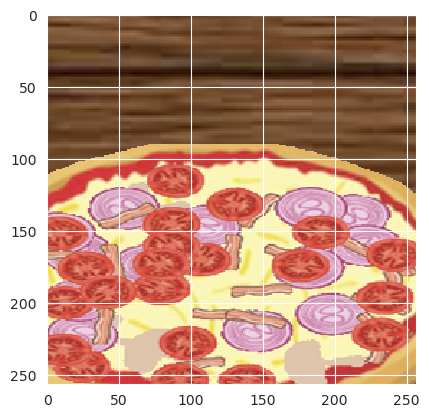

In [13]:
idx = 45

img_name = "{:04d}.png".format(idx+1)
print(img_name)
img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')

img = Image.open(os.path.join(img_path, img_name))
plt.imshow(img)
plt.show()

## A - First approach with a CNN

There are several possibilities to solve the problem:

* Extract good features and apply a simple predictor. The problem is to find good features for the problem: you know what they can be and how to compute them, or you can rely on "generic" features like bag of visual words, histograms or deep features.

* Work on raw data and build the label predictor directly. This is typically an approach for deep learning.

Notice that the problem is **multi-label prediction**, not classification. Each image may be characterized by several labels.


We decided to start with a simple CNN. There are 3 convolutions followed by 2 extra layers.

### Simple network definition

An elementary convolutional network with input datasize of 32x32.

In [14]:
# network class
class SimpleCNN(nn.Module):
# Network requires 32x32 input images  
  def __init__(self, nlabel = 10):
    super(SimpleCNN, self).__init__()
    self.nlabel = nlabel
    
    # define here the convolutions and linear layers
    self.conv1 = nn.Conv2d(3,16,3)
    self.conv2 = nn.Conv2d(16,32,3)
    self.conv3 = nn.Conv2d(32,64,3)
    self.lin1 = nn.Linear(256, 128)
    self.lin2 = nn.Linear(128, self.nlabel)
    
  def forward(self, x):
    
    # 32x32
    
    # define here the forward pass
    x1 = self.conv1(x)
    x1r = F.relu(x1)
    x1p = F.max_pool2d(x1r, 2)
    
    # 16x16
    x2 = self.conv2(x1p)
    x2r = F.relu(x2)
    x2p = F.max_pool2d(x2r, 2)
    
    # 8x8
    x3 = self.conv3(x2p)
    x3r = F.relu(x3)
    x3p = F.max_pool2d(x3r, 2)
    
    # 4x4
    y0 = x3p.view(x3p.size(0), -1)
    y1 = self.lin1(y0)
    y1r = F.relu(y1)
    y2 = self.lin2(y1r)
    
    return y2
    
tag = "simpleCNN"
if os.path.exists("networks/network_" + tag + ".pth"):
    print("Loading pretrained network")
    network = torch.load("networks/network_" + tag + ".pth")
else:
    network = SimpleCNN()

Loading pretrained network


### Create dataloaders

First we need to create the dataloader using the previously defined function.
In order to match the input size of simpleCNN, we had to modify the input_size and set it to 32.

In [15]:
batch_size = 25

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create the list of transformations that will be computed on the training pictures to make the model more robust
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize((input_size, input_size)),
                                         transforms.ToTensor(),
                                     normalize])

# Create the list of transformations necessary for the data to fit the model
val_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                   normalize])
        
# Conversion of img_all to a ndarray
img_data=np.array(img_all) # an error occured and we noticed that img_data=np.array(img_all) appeared in np.savez_compressed. hence our idea to add that line


# Creation of the dataloader for the model training
train_data_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')
train_dataloader = create_dataloader(x_train, y_train, img_data, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


# Creation of the dataloader for the model validation
val_dataloader = create_dataloader(x_val, y_val, img_data, train_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


# Creation of the dataloader for the model test
test_data_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')
test_dataloader = create_dataloader(x_test, y_test, None, test_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)

### Displaying the training dataloader
Before continuing, let's check what the dataloader will actually send to the CNN. It also allows to validate the dataloaders.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 3, 32, 32])


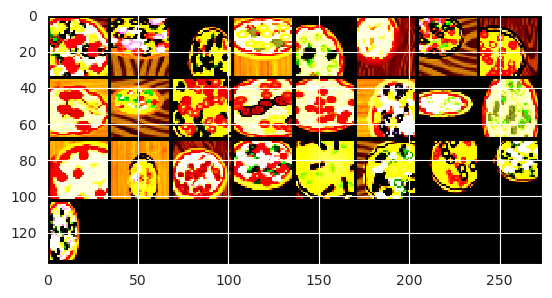

In [16]:
# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(val_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

### The training procedure

In [17]:
# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the training function)
optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Training 
max_epoch = 20 # initial 20
trained_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

if input("Do you want to save ? (Y/n)") == "Y":
    torch.save(trained_model, os.path.join('networks/network_{:s}.pth'.format(tag)))

network = trained_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)

0 / 2
	loss= tensor(6.4592, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(7.0105, device='cuda:0', grad_fn=<DivBackward1>)
1 / 2

Do you want to save ? (Y/n)n
Train accuracies
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.04, 0.04, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.04, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.08, 0.04, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.08, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.08, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04, 0.08, 0.0, 0.08, 0.0, 0.0, 0.12, 0.0, 0.04, 0.04, 0.0, 0.08, 0.04, 0.0, 0.0, 0.08, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 

### Evaluate the performances of the network

This part computes KPI and displays the predictions of the network. The visual part allowed us to make the project more tangible and fun.

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 28.49it/s]


Accuracy per label : [[0.77665996 0.54929577 0.47484909 0.72635815 0.65593561 0.57746479
  0.69215292 0.63179074 0.63179074 0.8832998 ]]
Mean of accuracy : 0.6599597585513078
              precision    recall  f1-score   support

   pepperoni       0.57      0.74      0.65       137
   mushrooms       0.34      0.58      0.43       146
     peppers       0.30      0.53      0.38       152
      olives       0.53      0.59      0.56       146
       basil       0.45      0.75      0.56       145
       bacon       0.36      0.39      0.38       162
    broccoli       0.53      0.79      0.63       169
   pineapple       0.41      0.50      0.45       149
    tomatoes       0.47      0.85      0.60       164
      onions       0.82      0.84      0.83       168

   micro avg       0.47      0.66      0.54      1538
   macro avg       0.48      0.66      0.55      1538
weighted avg       0.48      0.66      0.55      1538
 samples avg       0.48      0.69      0.52      1538



Batch n°19


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


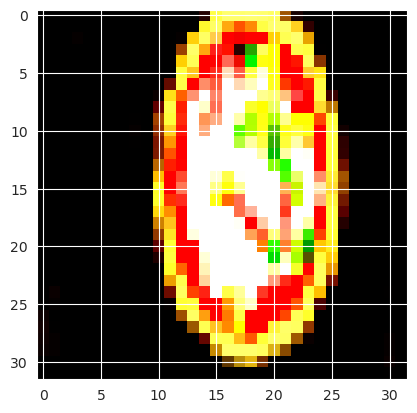

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, olives, basil, pineapple
Correct answer is basil, bacon, pineapple






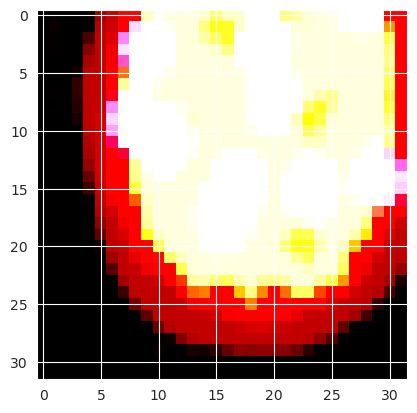

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, olives, onions
Correct answer is onions






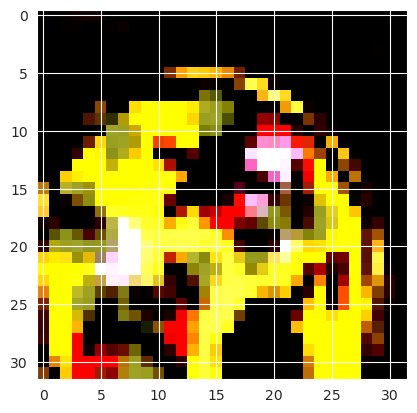

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, bacon, tomatoes
Correct answer is mushrooms, olives, bacon, tomatoes, onions






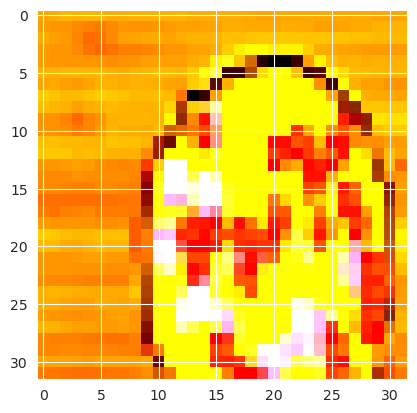

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, broccoli, tomatoes, onions
Correct answer is pineapple, tomatoes, onions






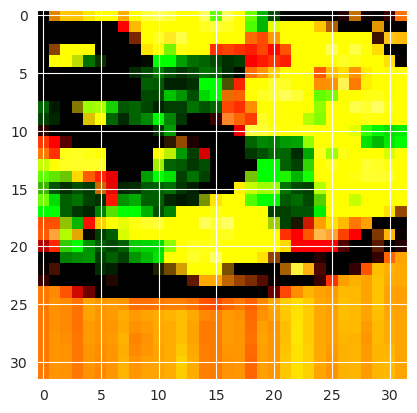

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds basil, broccoli
Correct answer is peppers, olives, basil, broccoli, pineapple, tomatoes






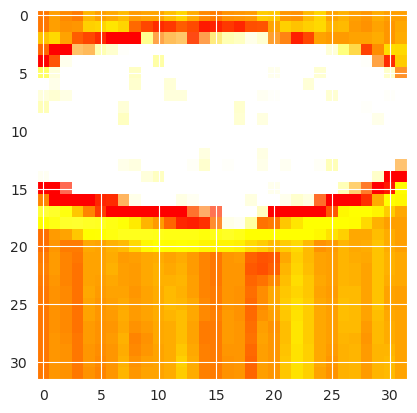

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, basil, bacon, broccoli, pineapple
Correct answer is mushrooms






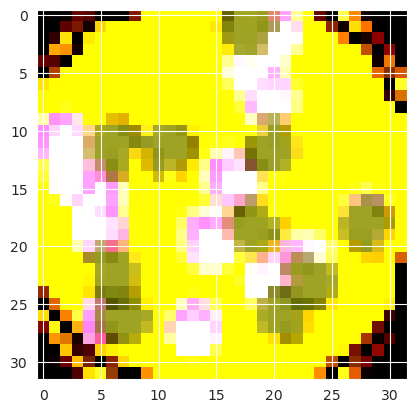

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, basil, broccoli, onions
Correct answer is mushrooms, onions






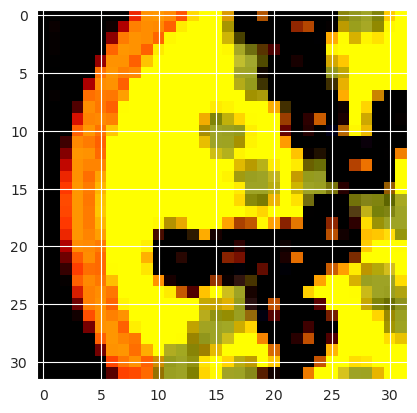

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, olives, bacon, pineapple, onions
Correct answer is mushrooms, olives






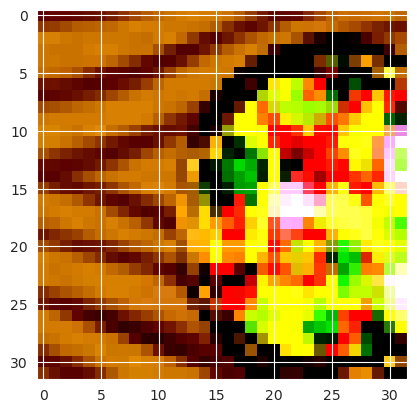

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds basil, broccoli, tomatoes, onions
Correct answer is basil, bacon, broccoli, tomatoes, onions






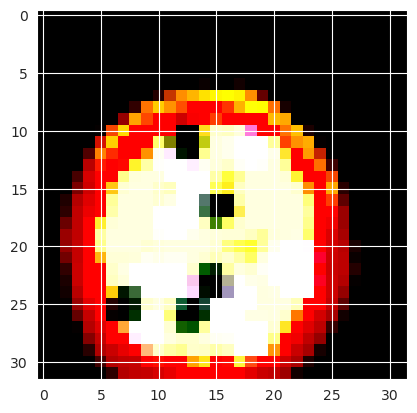

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, basil, broccoli, tomatoes, onions
Correct answer is basil, onions






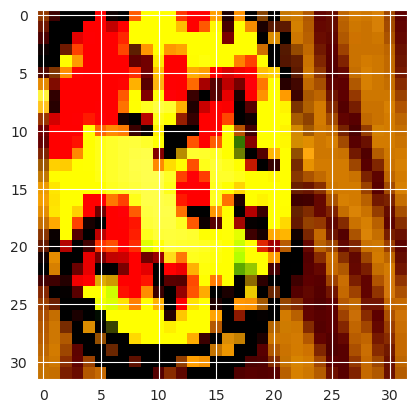

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, olives, bacon, pineapple, tomatoes
Correct answer is pepperoni, basil, bacon






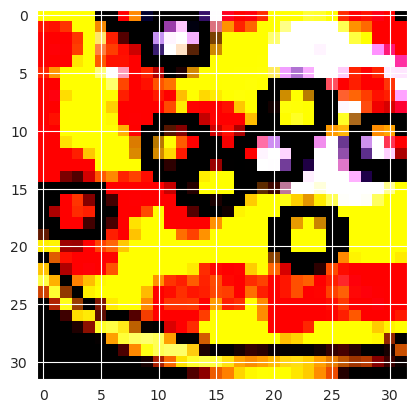

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds olives, bacon
Correct answer is pepperoni, olives, tomatoes, onions






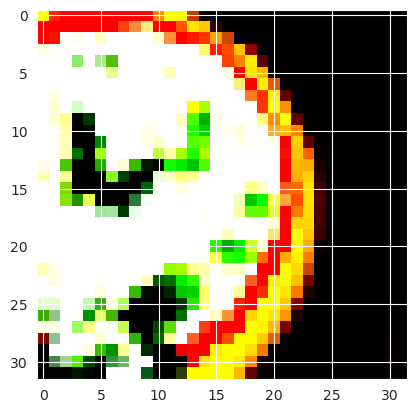

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, basil, broccoli, pineapple
Correct answer is mushrooms, basil, broccoli






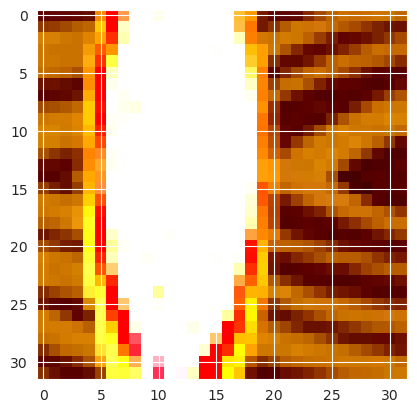

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, basil, bacon, broccoli, pineapple
Correct answer is mushrooms






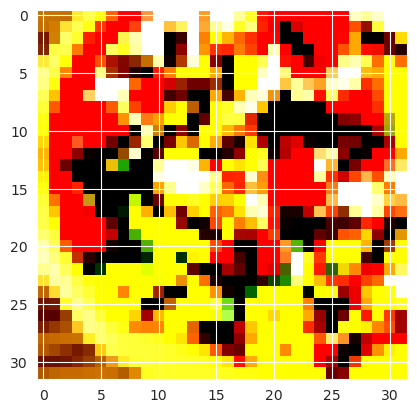

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, bacon, tomatoes
Correct answer is peppers, bacon, broccoli, pineapple, tomatoes






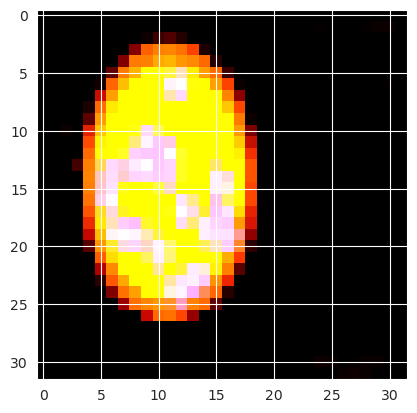

IA finds mushrooms, basil, broccoli, tomatoes, onions
Correct answer is onions






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


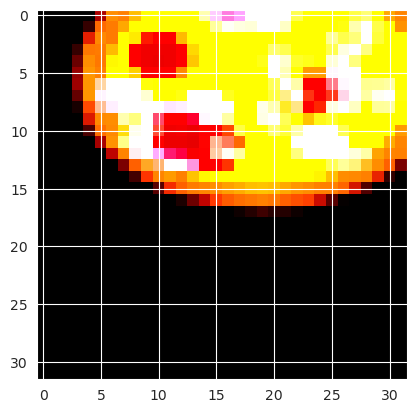

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, mushrooms, peppers, tomatoes, onions
Correct answer is pepperoni, mushrooms, onions






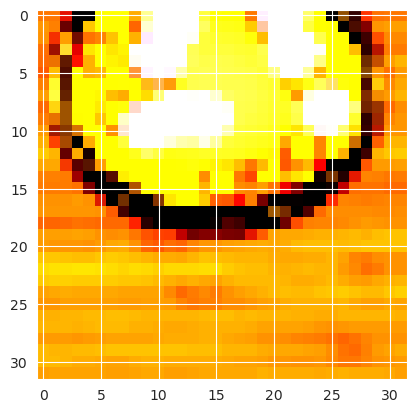

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, olives, pineapple, onions
Correct answer is peppers, onions






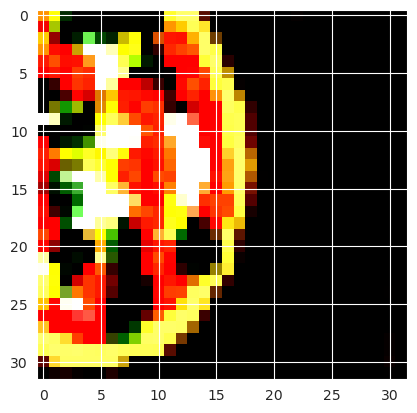

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, peppers, basil, broccoli, tomatoes
Correct answer is olives, broccoli, pineapple, tomatoes






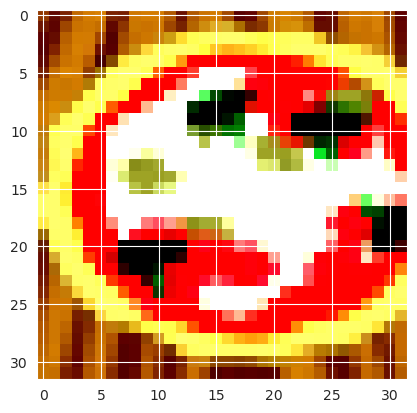

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, basil, broccoli, tomatoes
Correct answer is pepperoni, mushrooms, broccoli






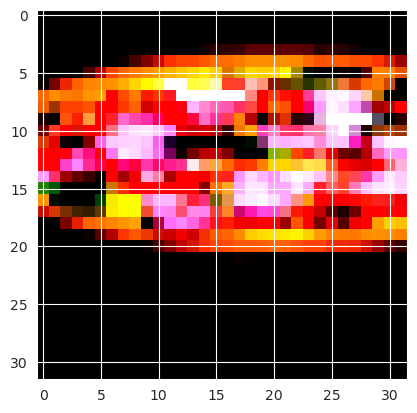

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, broccoli, tomatoes, onions
Correct answer is pepperoni, mushrooms, peppers, olives, bacon, broccoli, tomatoes, onions






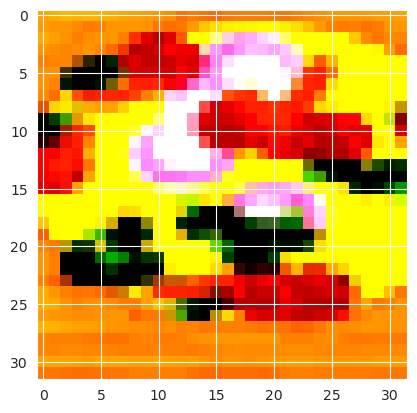

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, basil, broccoli, tomatoes, onions
Correct answer is pepperoni, bacon, broccoli, onions






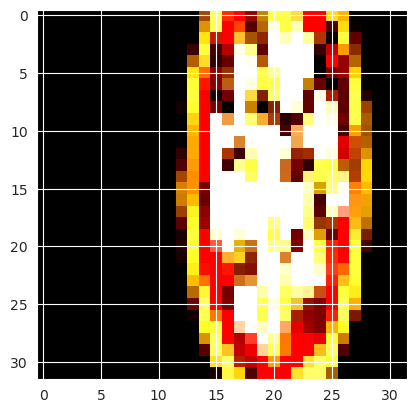

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni
Correct answer is mushrooms, bacon






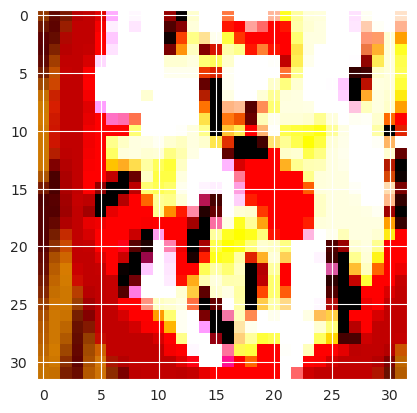

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, peppers, olives, bacon, tomatoes, onions
Correct answer is mushrooms, bacon, tomatoes, onions






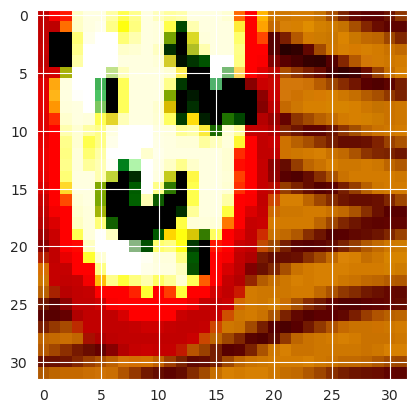

IA finds peppers, basil, broccoli, tomatoes, onions
Correct answer is mushrooms, basil






In [18]:
perf_label_test, metrics_report = model_evaluation(network = network, dataloader=test_dataloader, labels=topping_labels, nb_labels=nlabel, display=1)

# show what the network guessed on a random batch
show_result_on_random_batch(network, topping_labels, test_dataloader)

## Our results concerning simpleCNN on the synthetic dataset

The performance indicators are based on the test dataset.

There is an improvement of the mean accuracy of about 10% between the epoch 50 and 3150. There is a big fall in almost all indicators around the epoch 1650. Because we don't have any indicators on the train or validation datasets, we can't claim that it is due to overfitting.

Loading data from /home/seb/workspace/Topping-Pizza/performances/simpleCNN_efficiency.json



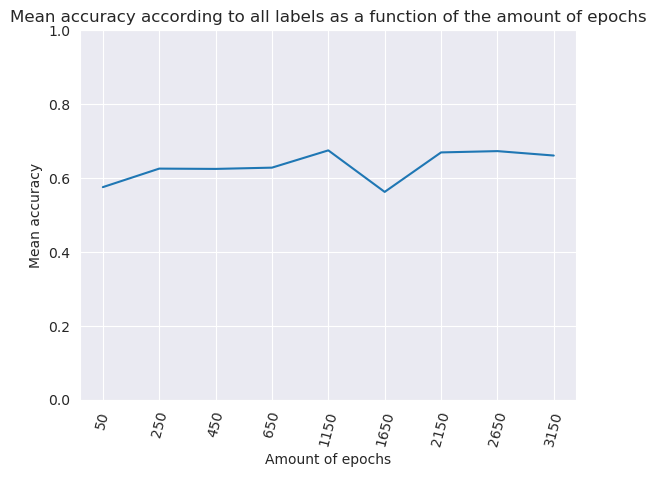

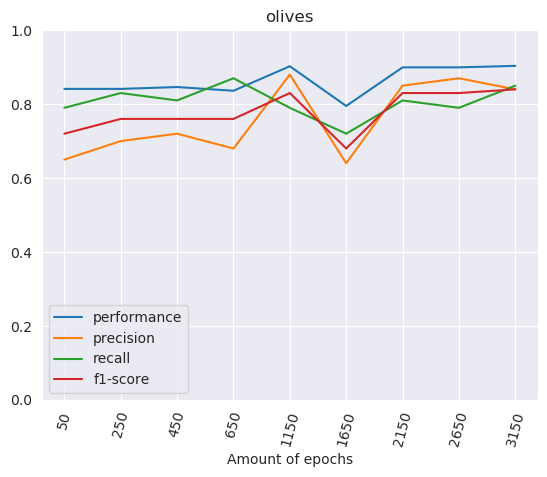

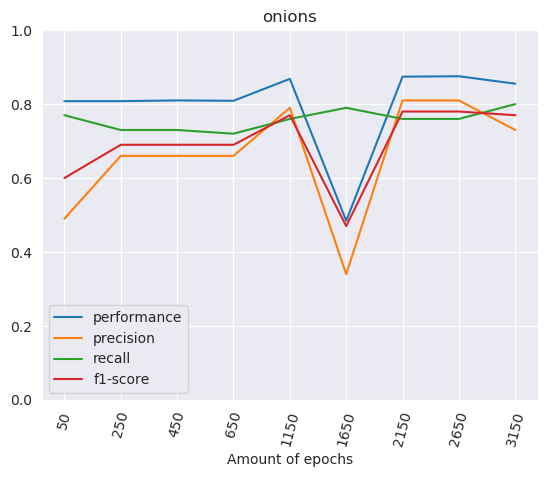

In [19]:
display_graph("simpleCNN_efficiency.json", labels_list = ["olives", "onions"])

## B - A second approach using efficientNet

Now, we'll use efficientNet with the default weights and retrain the model with the dataset.

Because the image resolution needs to be 224x224 (versus 32x32 previously), the dataloaders need to be recreated.



In [35]:
batch_size = 25
input_size = 224

x_train, y_train, x_val, y_val, x_test, y_test = load_image_list('syntheticDataset/train/trainLabels.txt',
                                                                'syntheticDataset/test/testLabels.txt',
                                                                 val_size=0.1)
# TODO remove next two lines 
nlabel = y_train.shape[1]
topping_labels = ["pepperoni", "mushrooms", "peppers", "olives", "basil", "bacon", "broccoli", "pineapple", "tomatoes", "onions"]
img_all = store_image(np.concatenate((x_train, x_val)), 'syntheticDataset/train', 'img_data_224.npz')

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create the list of transformations that will be computed on the training pictures to make the model more robust
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize((input_size, input_size)),
                                         transforms.ToTensor(),
                                     normalize])

# Create the list of transformations necessary for the data to fit the model
val_transform = transforms.Compose([transforms.Resize((input_size, input_size)),
                                    transforms.ToTensor(),
                                   normalize])
        
# Conversion of img_all to a ndarray
img_data=np.array(img_all) # an error occured and we noticed that img_data=np.array(img_all) appeared in np.savez_compressed. hence our idea to add that line


# Creation of the dataloader for the model training
train_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/train/images')
train_dataloader = create_dataloader(x_train, y_train, img_data, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


# Creation of the dataloader for the model validation
val_dataloader = create_dataloader(x_val, y_val, img_data, train_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


# Creation of the dataloader for the model test
test_data_path=img_path = os.path.join(DATA_DIR, 'syntheticDataset/test/images')
test_dataloader = create_dataloader(x_test, y_test, None, test_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)

(4473, 10)
(498, 10)
(497, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([25, 3, 224, 224])


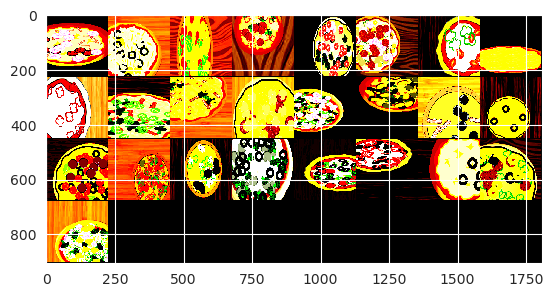

In [36]:
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

Then we load a pre-trained effecientNet network from torchvision

In [37]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

tag = "efficientNet"

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel) # layer to match to the number of labels

if os.path.exists("networks/network_synthetic_" + tag + ".pth"):
    print("Loading pretrained network")
    network = torch.load("networks/network_synthetic_" + tag + ".pth")

# Transfer network to GPU
network.to(device)

Loading pretrained network


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### The training procedure

Despite the network being pre-trained, the weights have to be adjusted to our project in order to get decent performances.

In [23]:
# Define learning components (to be used in the learning function)
optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Learning 
max_epoch = 20 # initial 20
learned_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

if input("Do you want to save ? (Y/n)") == "Y":
    torch.save(learned_model, os.path.join('networks/network_synthetic_{:s}.pth'.format(tag)))

network = learned_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)

0 / 2
	loss= tensor(19.4037, device='cuda:0', grad_fn=<DivBackward1>)
1 / 2
	loss= tensor(10.7355, device='cuda:0', grad_fn=<DivBackward1>)

Do you want to save ? (Y/n)n
Train accuracies
[0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.04, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

### Evaluate the performances of the network

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 17.89it/s]


Accuracy per label : [[0.98792757 0.99195171 0.97987928 0.99597586 0.98792757 0.99396378
  0.98792757 0.98993964 0.98390342 0.99798793]]
Mean of accuracy : 0.989738430583501
              precision    recall  f1-score   support

   pepperoni       0.96      0.99      0.98       137
   mushrooms       0.98      0.99      0.99       146
     peppers       0.97      0.97      0.97       152
      olives       0.99      0.99      0.99       146
       basil       1.00      0.96      0.98       145
       bacon       1.00      0.98      0.99       162
    broccoli       0.97      0.99      0.98       169
   pineapple       0.98      0.99      0.98       149
    tomatoes       0.96      0.99      0.98       164
      onions       0.99      1.00      1.00       168

   micro avg       0.98      0.99      0.98      1538
   macro avg       0.98      0.99      0.98      1538
weighted avg       0.98      0.99      0.98      1538
 samples avg       0.98      0.98      0.98      1538



Batch n°17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


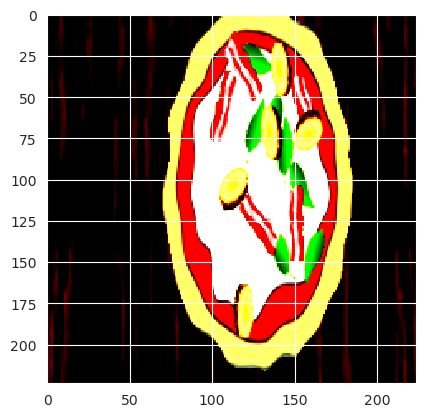

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds basil, bacon, pineapple
Correct answer is basil, bacon, pineapple






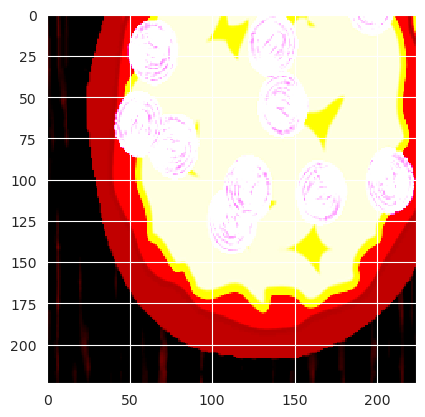

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds onions
Correct answer is onions






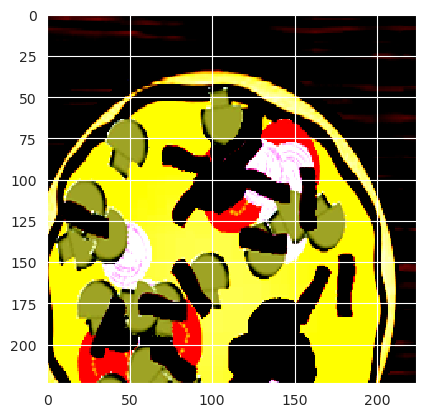

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, olives, bacon, tomatoes, onions
Correct answer is mushrooms, olives, bacon, tomatoes, onions






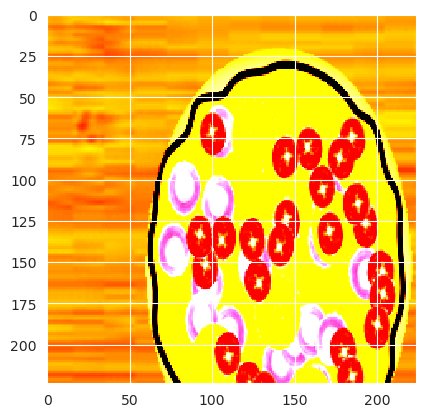

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pineapple, tomatoes, onions
Correct answer is pineapple, tomatoes, onions






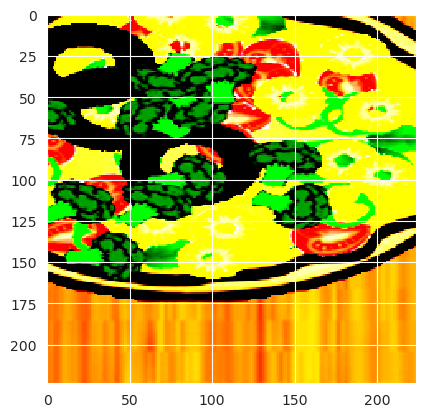

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds peppers, olives, broccoli, pineapple, tomatoes
Correct answer is peppers, olives, basil, broccoli, pineapple, tomatoes






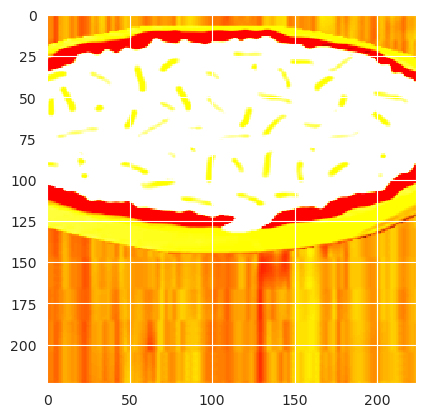

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms
Correct answer is mushrooms






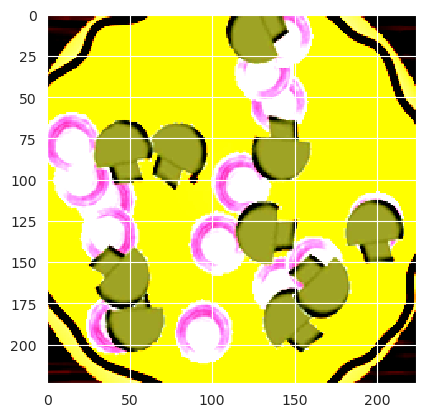

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, onions
Correct answer is mushrooms, onions






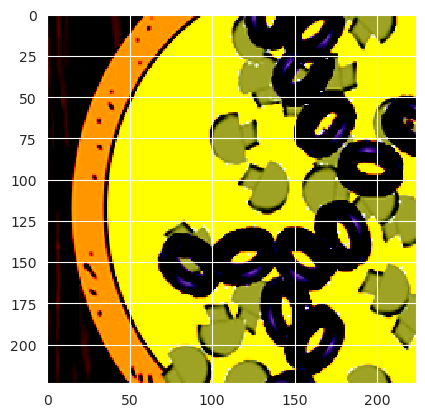

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, olives
Correct answer is mushrooms, olives






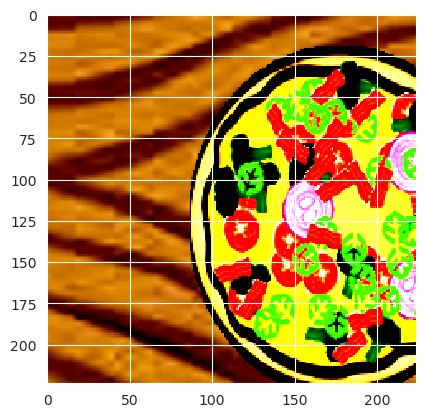

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds basil, bacon, broccoli, tomatoes, onions
Correct answer is basil, bacon, broccoli, tomatoes, onions






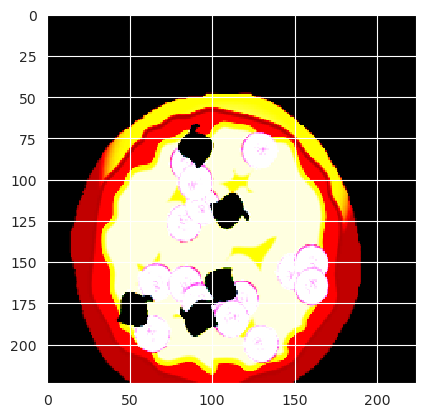

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds basil, onions
Correct answer is basil, onions






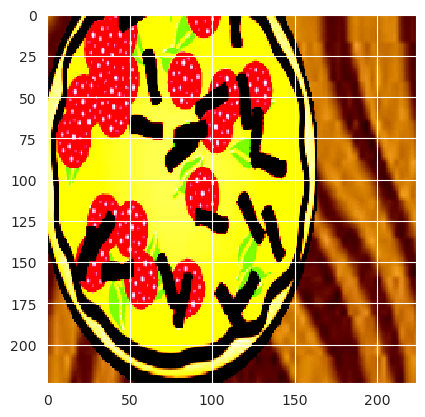

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, basil, bacon
Correct answer is pepperoni, basil, bacon






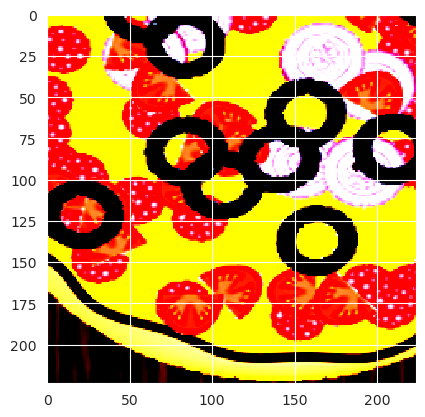

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, olives, tomatoes, onions
Correct answer is pepperoni, olives, tomatoes, onions






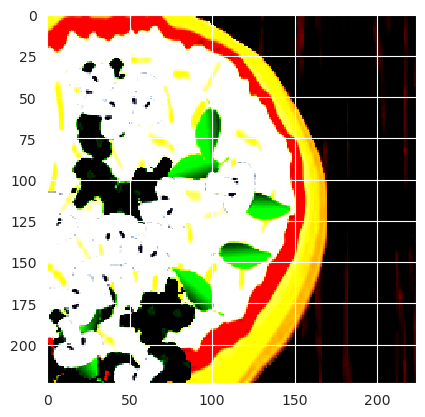

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, basil, broccoli
Correct answer is mushrooms, basil, broccoli






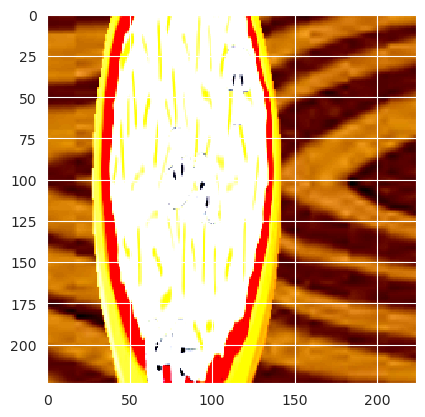

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms
Correct answer is mushrooms






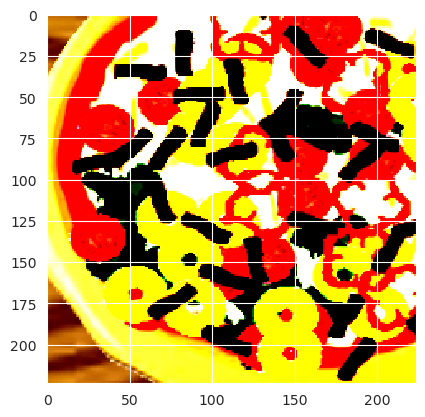

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds peppers, bacon, broccoli, pineapple, tomatoes
Correct answer is peppers, bacon, broccoli, pineapple, tomatoes






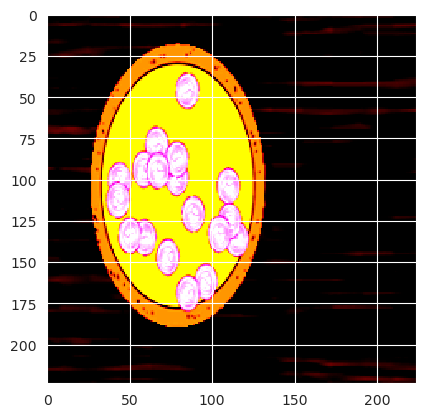

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds onions
Correct answer is onions






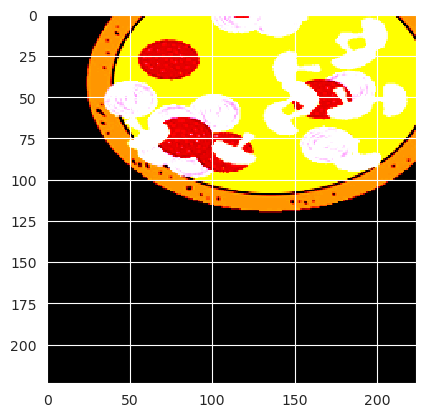

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, mushrooms, onions
Correct answer is pepperoni, mushrooms, onions






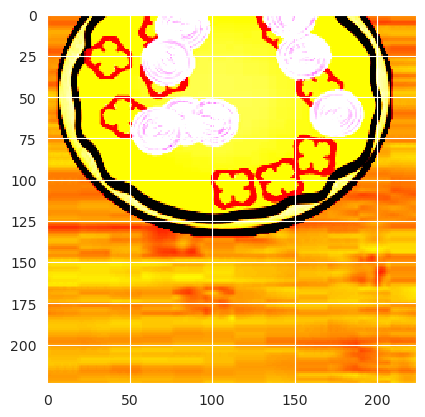

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds peppers, onions
Correct answer is peppers, onions






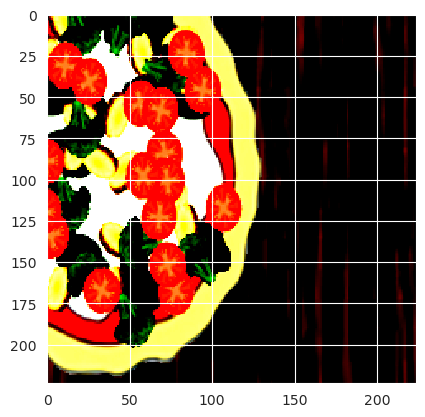

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds olives, broccoli, pineapple, tomatoes
Correct answer is olives, broccoli, pineapple, tomatoes






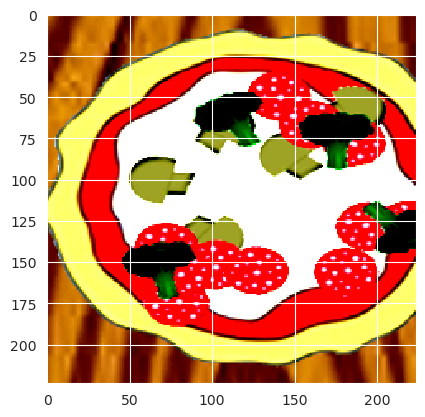

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, mushrooms, broccoli
Correct answer is pepperoni, mushrooms, broccoli






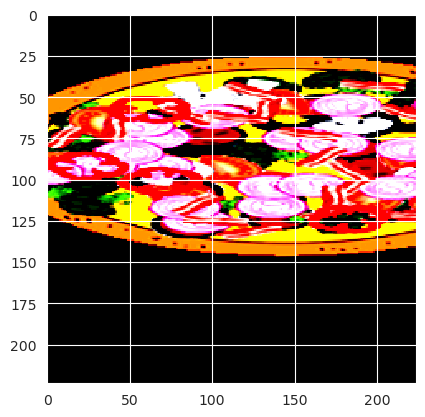

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds pepperoni, mushrooms, olives, bacon, broccoli, tomatoes, onions
Correct answer is pepperoni, mushrooms, peppers, olives, bacon, broccoli, tomatoes, onions






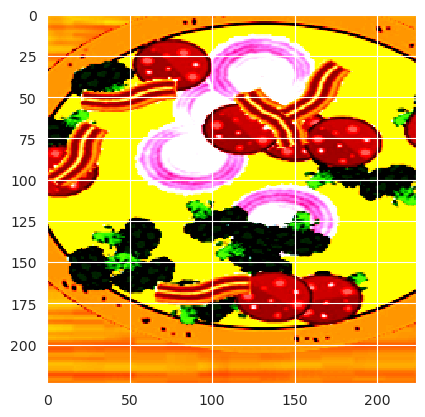

IA finds pepperoni, bacon, broccoli, onions
Correct answer is pepperoni, bacon, broccoli, onions






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


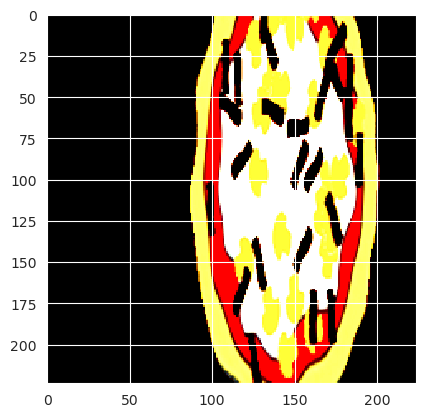

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, peppers, bacon
Correct answer is mushrooms, bacon






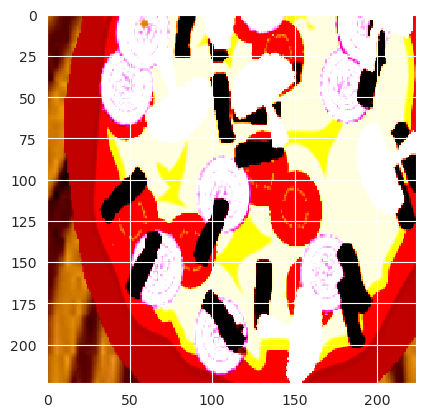

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds mushrooms, bacon, tomatoes, onions
Correct answer is mushrooms, bacon, tomatoes, onions






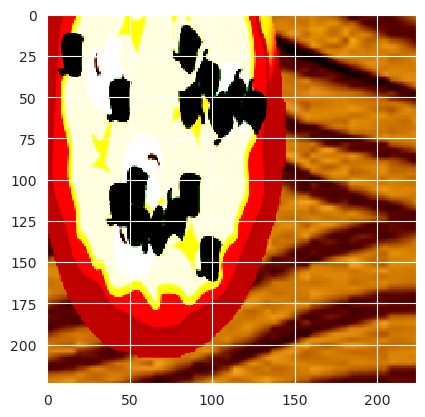

IA finds mushrooms, basil
Correct answer is mushrooms, basil






In [38]:
perf_label_test, metrics_report = model_evaluation(network = network, dataloader=test_dataloader, labels=topping_labels, nb_labels=nlabel, display=1)

# show what the network guessed on a random batch
show_result_on_random_batch(network, topping_labels, test_dataloader)

## Our results concerning efficientNET on the synthetic dataset

The performance indicators are based on the test dataset.

The overall performance at the end of the training is excellent : 98,97% (mean of accuracy). Also the other indicators are close to one which is great. We remind our dear reader the meaning of the indicators that we used :

*   Precision : TP/(TP+FP) --> Ability to predict the positive class. Closer to 1 = better
*   Recall : TP/(TP+FN) --> Ability to detect positives. Closer to 1 = better
*   F1-score : 2.precision.recall/(precision+recall). Closer to 1 = better

Moreover, all the graphs of particular labels are similar no matter the indicators _(you can try by changing the `labels_list` in the code. The complete `labels_list` is `["pepperoni", "mushrooms", "peppers", "olives", "basil", "bacon", "broccoli", "pineapple", "tomatoes", "onions"]`)_

Loading data from /home/seb/workspace/Topping-Pizza/performances/training_performance_evolution.json



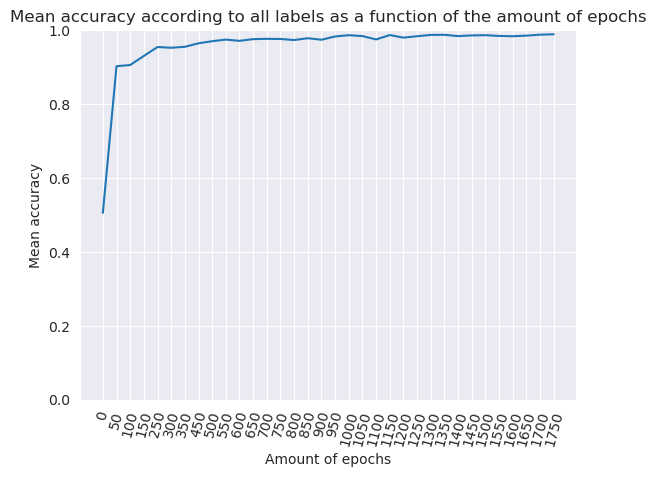

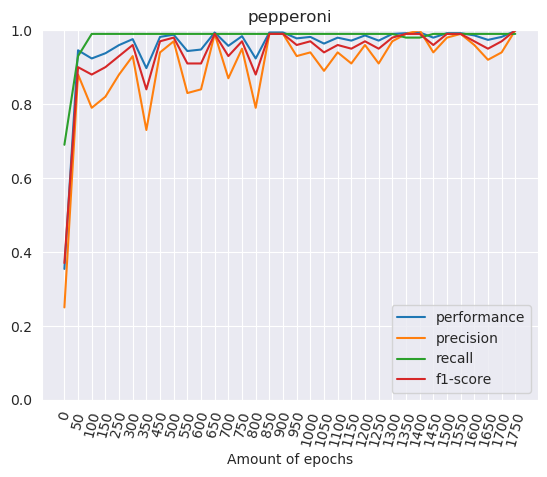

In [25]:
display_graph("training_performance_evolution.json", labels_list=["pepperoni"])

# 2 - Finding topping of real pizzas

As the network did a really good job on the synthetic dataset, we wanted to try on the real images!

In [26]:
DATA_DIR =  './pizzaGANdata'



x_train, y_train, x_val, y_val, x_test, y_test = load_image_list('imageLabels.txt',
                                                                test_size=0.2,
                                                                val_size=0.1,
                                                                max_image=2000)


img_all = store_image(np.concatenate((x_train, x_val)), '', 'img_data.npz', image_format="{:05d}.png", image_size=500, )

nlabel = y_train.shape[1]
topping_labels = ["Pepperoni", "Bacon", "Mushrooms", "Onions",
              "Peppers", "Black olives", "Tomatoes", "Spinach", "Fresh basil",
               "Arugula", "Broccoli", "Corn", "Pineapple"]

(1400, 13)
(200, 13)
(400, 13)


In [27]:
batch_size = 5 # Reduced batch size because of limitation on my graphic card

input_size = 500

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create the list of transformations that will be computed on the training pictures to make the model more robust
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomVerticalFlip(),
                                         transforms.ColorJitter(brightness=32. / 255., saturation=0.5),
                                         transforms.Resize(input_size),
                                         transforms.ToTensor(),
                                     normalize])

# Create the list of transformations necessary for the data to fit the model
val_transform = transforms.Compose([transforms.Resize(input_size),
                                    transforms.ToTensor(),
                                   normalize])
        
# Conversion of img_all to a ndarray
img_data=np.array(img_all) # an error occured and we noticed that img_data=np.array(img_all) appeared in np.savez_compressed. hence our idea to add that line


# Creation of the dataloader for the model training
train_data_path=img_path = os.path.join(DATA_DIR, 'images')
train_dataloader = create_dataloader(x_train, y_train, img_data, train_data_path, myDataset, batch_size, transform=train_transform, shuffle=True)


# Creation of the dataloader for the model validation
val_dataloader = create_dataloader(x_val, y_val, img_data, train_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)


# Creation of the dataloader for the model test
test_data_path=img_path = os.path.join(DATA_DIR, 'images')
test_dataloader = create_dataloader(x_test, y_test, img_data, test_data_path, myDataset, batch_size, transform=val_transform, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 500, 500])


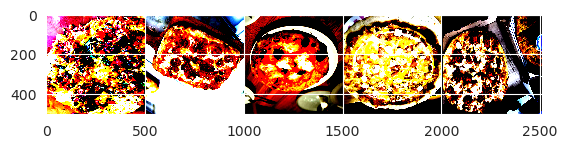

In [28]:
# Show batch of images
#it = iter(train_dataloader)
sample,labels = next(iter(train_dataloader))
print(sample.shape)

out = torchvision.utils.make_grid(sample)
plt.imshow(out.permute(1, 2, 0))

In [29]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

tag = "efficientNet"

network = torchvision.models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = network.classifier[1].in_features
network.classifier[1]= nn.Linear(num_ftrs, nlabel) # layer to match to the number of labels

if os.path.exists("networks/network_real_" + tag + ".pth"):
    print("Loading pretrained network")
    network = torch.load("networks/network_real_" + tag + ".pth")

Loading pretrained network


In [30]:
# Transfer network to GPU
network.to(device)

# Define learning components (to be used in the training function)
optimizer = optim.Adam(network.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()
scheduler = None

# Training 
max_epoch = 20 # initial 20
trained_model, train_error, test_error, train_losses = train_model_multilabel(network, nlabel, train_dataloader, val_dataloader, criterion, optimizer, scheduler, num_epochs=max_epoch)

if input("Do you want to save ? (Y/n)") == "Y":
    torch.save(trained_model, os.path.join('networks/network_real_{:s}.pth'.format(tag)))

network = trained_model

print("Train accuracies")
print(train_error)
print("Test accuracies")
print(test_error)
print("Train losses")
print(train_losses)

0 / 2
	loss= tensor(0.6642, device='cuda:0', grad_fn=<DivBackward1>)
1 / 2
	loss= tensor(0.2780, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(0.9705, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(0.2816, device='cuda:0', grad_fn=<DivBackward1>)
	loss= tensor(0.2871, device='cuda:0', grad_fn=<DivBackward1>)

Do you want to save ? (Y/n)n
Train accuracies
[0.8, 0.4, 0.6, 0.4, 0.6, 0.6, 0.4, 0.6, 0.4, 0.4, 0.8, 0.2, 0.8, 0.4, 0.8, 0.8, 0.8, 0.8, 0.2, 0.4, 0.6, 0.4, 0.6, 0.2, 0.0, 0.6, 0.6, 0.6, 0.0, 0.6, 0.4, 0.8, 0.4, 0.6, 0.8, 0.6, 0.6, 0.8, 0.8, 0.6, 0.8, 0.8, 0.8, 0.6, 0.6, 0.4, 0.6, 0.6, 0.6, 0.6, 1.0, 0.4, 0.6, 0.0, 1.0, 0.6, 0.6, 0.4, 0.2, 0.6, 0.0, 0.4, 0.4, 0.2, 0.6, 0.4, 0.4, 0.4, 0.4, 0.2, 0.8, 0.8, 0.6, 0.4, 0.2, 0.6, 0.6, 0.8, 0.4, 0.4, 0.6, 0.2, 0.4, 0.2, 0.2, 0.6, 0.6, 0.8, 0.8, 0.4, 0.4, 0.6, 0.6, 0.8, 0.8, 0.8, 0.6, 0.4, 0.6, 0.4, 0.4, 0.8, 0.4, 0.8, 0.2, 0.0, 0.4, 0.6, 0.6, 0.2, 0.6, 0.6, 0.2, 0.8, 0.8, 0.4, 0.4, 0.8, 0.4, 0.8, 0.4, 0.6, 0.6, 0.8, 0.4,

100%|███████████████████████████████████████████| 80/80 [00:09<00:00,  8.61it/s]


Accuracy per label : [[0.72   0.9175 0.7275 0.7    0.6875 0.8075 0.7125 0.7375 0.685  0.95
  0.9675 0.9275 0.905 ]]
Mean of accuracy : 0.8034615384615384
              precision    recall  f1-score   support

   Pepperoni       0.44      0.98      0.61        88
       Bacon       0.20      0.58      0.30        12
   Mushrooms       0.32      0.93      0.48        54
      Onions       0.24      0.90      0.38        40
     Peppers       0.27      0.94      0.42        48
Black olives       0.34      0.93      0.50        41
    Tomatoes       0.41      0.84      0.55        85
     Spinach       0.15      0.75      0.26        24
 Fresh basil       0.38      0.95      0.55        80
     Arugula       0.44      1.00      0.62        16
    Broccoli       0.20      0.75      0.32         4
        Corn       0.22      1.00      0.36         8
   Pineapple       0.03      0.25      0.05         4

   micro avg       0.32      0.90      0.47       504
   macro avg       0.28      0.83

Batch n°1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


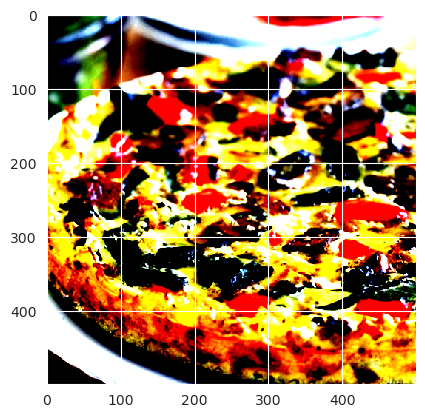

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds Mushrooms, Onions, Peppers, Black olives, Tomatoes
Correct answer is Mushrooms, Tomatoes, Spinach






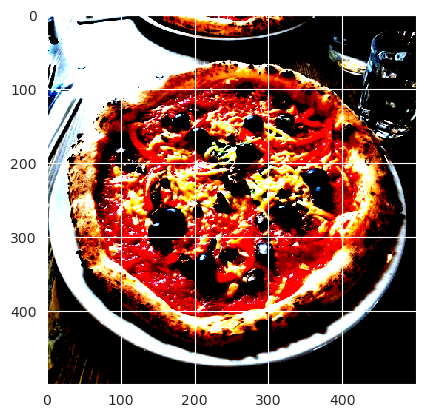

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds Pepperoni, Black olives, Tomatoes, Fresh basil
Correct answer is Peppers, Black olives






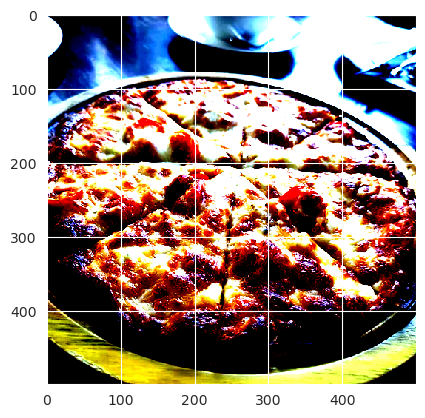

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds Pepperoni, Tomatoes
Correct answer is 






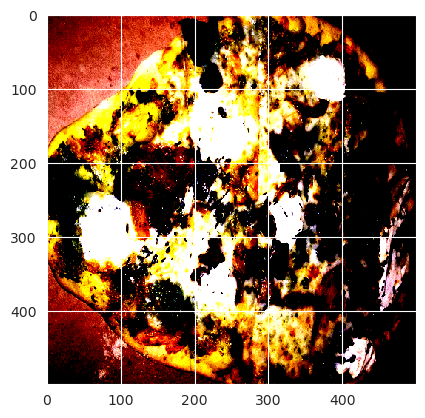

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IA finds Mushrooms, Onions, Peppers, Spinach
Correct answer is Mushrooms






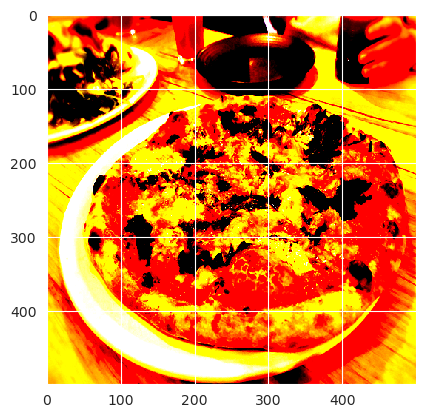

IA finds Spinach, Fresh basil
Correct answer is Spinach






In [31]:
perf_label_test, metrics_report = model_evaluation(network = network, dataloader=test_dataloader, labels=topping_labels, nb_labels=nlabel, display=1)

# show what the network guessed on a random batch
show_result_on_random_batch(network, topping_labels, test_dataloader)

## Our results concerning effecientNet on the real dataset

First, due to limitation of our computers, we limited the dataset to 2000 images of size 500x500. Also the batch_size was reduced to 5 instead of 25.

Woaww! The accuracy is suprisingly high for each label.

BUT, the network isn't that great. Indeed, the precision is rather low and the recall high which means that the AI tries lot of labels but most of them are wrong. This is clearly noticeable while reviewing pictures, predictions and correct answers. The accuracy is high because the images of the dataset rarely contain lot of toppings so the AI can easily increase the accuracy thanks to true negatives.

Therefore, that may be fixed by using more of the dataset and trying another criterion.

Loading data from /home/seb/workspace/Topping-Pizza/performances/efficientNet_real_efficiency.json



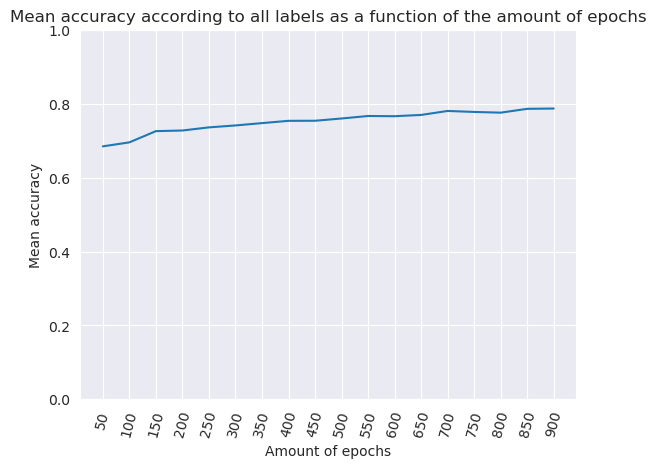

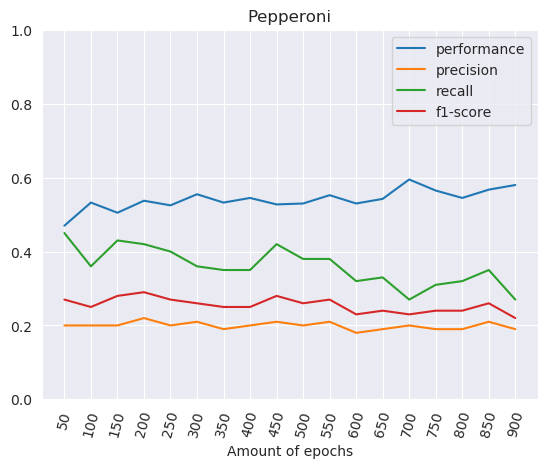

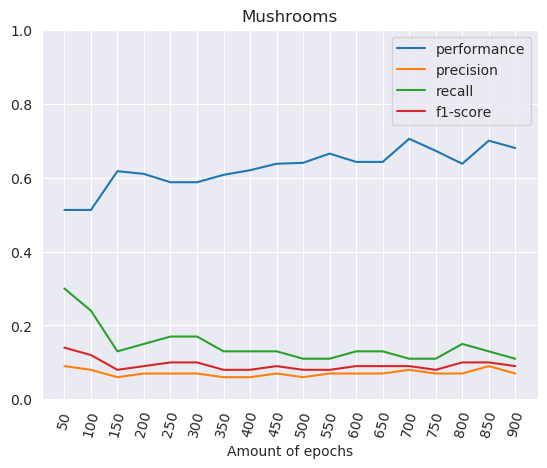

In [32]:
display_graph("efficientNet_real_efficiency.json", labels_list = ["Pepperoni", "Mushrooms"])